In [1]:
# knjižnice:

import pandas as pd
import numpy as np
import os.path
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import statsmodels.api as sm
from statsmodels.graphics import tsaplots
from sklearn.linear_model import LinearRegression
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.arima_model import ARIMA
import pmdarima as pm
import arch
from datetime import datetime, timedelta

In [21]:
# uvoz podatkov:

# podatki, ki so nam jih poslali:
podatki = pd.read_csv(os.path.join('C:/Users/Uporabnik/OneDrive/Namizje/SOLA/MAGISTERIJ/MATEMATIKA Z RACUNALNIKOM/GospodinjskiOdjemalci.csv'), sep=";")
# Malo boljši format:
podatki['DateTimeStartUTC'] = pd.to_datetime(podatki['DateTimeStartUTC'], format='%d.%m.%Y %H:%M')
podatki['DateTimeStartCET'] = pd.to_datetime(podatki['DateTimeStartCET'], format='%d.%m.%Y %H:%M')

podatki = podatki[['DateTimeStartUTC', 'Odjem ACT', 'Temperatura ACT', 'Temperatura FC', 'Sevanje ACT', 'Sevanje FC']]

podatki.set_index('DateTimeStartUTC', inplace=True)
podatki['Year'] = podatki.index.year
podatki['Month'] = podatki.index.month
podatki['Day'] = podatki.index.date
podatki['Time'] = podatki.index.time

podatki = podatki.asfreq('15T')

# log returns:
podatki['log return'] = np.log(podatki['Odjem ACT']/podatki['Odjem ACT'].shift(-1))
podatki = podatki.dropna()

# diferenciramo:
ts_diff = podatki['log return'].diff(periods = 96).dropna()


C:\Users\Uporabnik\AppData\Local\Temp\ipykernel_7816\2898791646.py:17: FutureWarning: 'T' is deprecated and will be removed in a future version, please use 'min' instead.
  podatki = podatki.asfreq('15T')


In [3]:
# pomožne funkcije:

def RMSE_MAPE (podatki_OG, napoved):
    '''Funkcija RMSE_MAPE izračuna napaki RMSE in MAPE. Vrne seznam oblike [RMSE, MAPE]'''
    errors = podatki_OG - napoved
    mse = np.mean(errors**2)
    rmse = np.sqrt(mse)
    mape = np.mean(np.abs(errors / podatki_OG)) * 100
    return [rmse, mape]

def napoved_na_OG_skala (podatki, napoved, dan, naslednji_dan):
    '''Napovedane podatke da v originalno skalo: najprej dediferenciramo in nato naredimo inverz log returnov.'''
    napoved_ = napoved + podatki['log return'].shift(-96)[dan]
    
    start = dan + ' 00:00:00'
    end = naslednji_dan + ' 00:00:00'

    return(np.exp(napoved_ + np.log(podatki.loc[start:end, 'Odjem ACT'].shift(-1)[dan])))

def ARIMA_exog(p, d, q, train, exog):
    '''Izračuna ARIMA(p,d,q)(0,1,0)[96] z eksogenimi podatki'''
    model = sm.tsa.statespace.SARIMAX(train, order=(p, d, q), exog = exog)
    results = model.fit()
    return results

def GARCH (residuali, p, q):
    '''Na podlagi podanih residualov izračuna GARCH(p,q)'''
    model = arch.arch_model(residuali, mean='Zero', vol='Garch', p=p, q=q)
    results = model.fit()
    return results


def forecast_exog (results, steps, exog):
    '''Na podlagi results naredi napoved z upoštevanjem eksogenih podatkov'''
    return results.forecast(steps=steps, exog=exog)

def SARIMA_GARCH_forecast(podatki, train_data, train_exog, test_data, test_exog, day, next_day):
    '''Funkcija naredi celotno SARIMA(4,1,5)(0,1,0)[96]-GARCH(1,3) napoved z upoštevanjem eksogenih podatkov'''
    results = ARIMA_exog(4, 1, 5, train_data, train_exog)
    forecast = forecast_exog(results, 96, test_exog)

    results_GARCH = GARCH(results.resid, 1, 3)
    forecastGARCH = results_GARCH.forecast(horizon=96)
    forecast_ = forecast.mean() + forecastGARCH.variance.values[-1, :]
    forecastDf = pd.DataFrame(forecast_, index=forecast.index, columns=['Forecast'])
    forecast_OG = napoved_na_OG_skala(podatki, forecastDf['Forecast'], day, next_day)

    return forecast_OG

def izrisi_graf_napovedi (podatki, napoved, naslov):
    '''Funkcija izrisi_graf_napovedi izriše graf napovedi'''
    sns.set(rc={'figure.figsize':(15, 6)}) 
    plt.style.use('seaborn-white')
    plt.plot(podatki, label='Dejanski podatki', color='slategrey', ls='--', linewidth=1.5)
    plt.plot(napoved, label='Napoved', color = 'royalblue', linewidth=2) # , color='orangered'
    plt.title(naslov, fontsize=20, weight='bold')
    plt.xlabel('Čas')
    plt.ylabel('Odjem')
    plt.legend()
    plt.show()

def naslednji_dan(date_str):
    '''Izpis naslednjega dne'''
    naslednji = (datetime.strptime(date_str, '%Y-%m-%d').date() + timedelta(1))
    return naslednji.strftime("%Y-%m-%d")

def prejsnji_dan(date_str):
    '''Izpis prejšnjega dne'''
    naslednji = (datetime.strptime(date_str, '%Y-%m-%d').date() + timedelta(-1))
    return naslednji.strftime("%Y-%m-%d") 
    

In [19]:
# glavna funkcije napoved_z_SARIMA_GARCH:

def napoved_z_SARIMA_GARCH(dan):
    '''
    Funkcija, ki za poljubni dan oblike 'yyyy-mm-dd':
                        - izriše graf napovedi ter dejanski odjem
                        - izpiše napaki RMSE in MAPE
    Do napak lahko tudi dostopamo, saj je return funkcije v obliki seznama [napovedane vrednsoti po urah, napaka RMSE, napak MAPE] 

    UPORABA:
    V funkcijo napoved_z_SARIMA_GARCH damo datum v obliki 'yyyy-mm-dd'.
    Najbolj je smiselno, da je datum iz testnega obdobja, torej med '2023-08-05' in '2024-02-28'. Sicer pa se dobi rezultat za vsah datum od '2021-11-03' naprej. 
    '''

    prev_day = prejsnji_dan(dan)
    next_day = naslednji_dan(dan)

    train_data_diff_96 = ts_diff['2021-11-02':prev_day] 
    train_exog = podatki.loc['2021-11-02':prev_day, ['Temperatura FC', 'Sevanje FC']]
    day = dan
    next_day = next_day
    test_data_diff_96 = ts_diff[day] 
    test_exog = podatki.loc[day, ['Temperatura FC', 'Sevanje FC']]

    forecast_AG = SARIMA_GARCH_forecast(podatki, train_data_diff_96, train_exog, test_data_diff_96, test_exog, day, next_day)    

    rmse_mape_AG = RMSE_MAPE(podatki.loc[day, 'Odjem ACT'], forecast_AG)

    izrisi_graf_napovedi(podatki.loc[day, 'Odjem ACT'], forecast_AG, dan)
    print("RMSE:", rmse_mape_AG[0])
    print("MAPE:", rmse_mape_AG[1])

    return [forecast_AG, rmse_mape_AG[0], rmse_mape_AG[1]]

# Funckija **napoved_z_SARIMA_GARCH**

### Kako funkcijo uporabiti?
V funkcijo napoved_z_SARIMA_GARCH damo datum v obliki 'yyyy-mm-dd'; npr. napoved_z_SARIMA_GARCH('2023-10-10') za napoved dne 10. oktober 2023.
Najbolj je smiselno, da je datum iz testnega obdobja, torej med '2023-08-05' in '2024-02-28'. Rezultat se sicer dobi za vsak datum od '2021-11-03' naprej. 

### Kaj funkcija vrne? 
Funkcije izriše prileganje grafa napovedi (po modelu SARIMA(4,1,5)(0,1,0)[96]-GARCH(1,3) z upoštevanjem eksogenih podatkov temperature in sevanja) dejanskemu odjemu. Prav tako izpiše napaki RMSE in MAPE.
Do napak lahko tudi dostopamo, saj je return funkcije napoved_z_SARIMA_GARCH v obliki seznama [napovedane vrednsoti po urah, napaka RMSE, napak MAPE].

### Koliko časa funkcija potrebuje da vrne rezultat? 
Okrog 1 minuto.

### Nekaj primerov:

### 1. Napoved za 10. oktober 2023:

c:\Users\Uporabnik\AppData\Local\Programs\Python\Python39\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\Uporabnik\AppData\Local\Programs\Python\Python39\lib\site-packages\arch\univariate\base.py:311: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0002015. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(


Iteration:      1,   Func. Count:      6,   Neg. LLF: -202081.87101223972
Optimization terminated successfully    (Exit mode 0)
            Current function value: -202081.87108646816
            Iterations: 5
            Function evaluations: 6
            Gradient evaluations: 1


C:\Users\Uporabnik\AppData\Local\Temp\ipykernel_7816\161216951.py:51: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn-white')


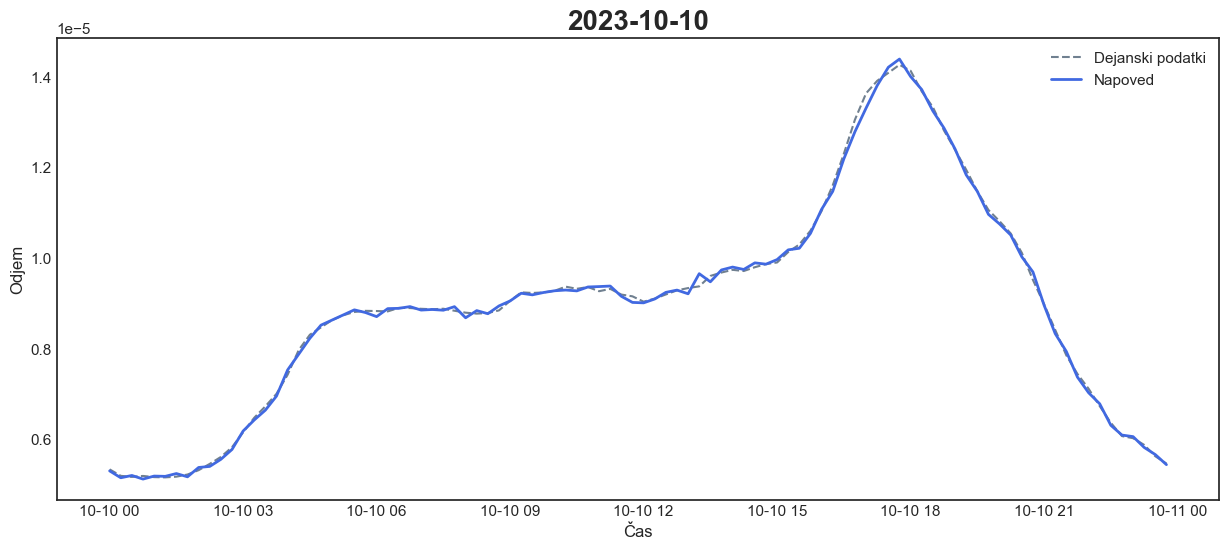

RMSE: 8.583078269396137e-08
MAPE: 0.7302950497184993


In [22]:
napoved_1 = napoved_z_SARIMA_GARCH('2023-10-10')

### 2. Napoved za 28. februar 2024:

c:\Users\Uporabnik\AppData\Local\Programs\Python\Python39\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\Uporabnik\AppData\Local\Programs\Python\Python39\lib\site-packages\arch\univariate\base.py:311: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0002008. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(


Iteration:      1,   Func. Count:      7,   Neg. LLF: 45084085331.16666
Iteration:      2,   Func. Count:     14,   Neg. LLF: -242659.05117762613
Optimization terminated successfully    (Exit mode 0)
            Current function value: -242659.05117304617
            Iterations: 6
            Function evaluations: 14
            Gradient evaluations: 2


C:\Users\Uporabnik\AppData\Local\Temp\ipykernel_7816\161216951.py:51: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn-white')


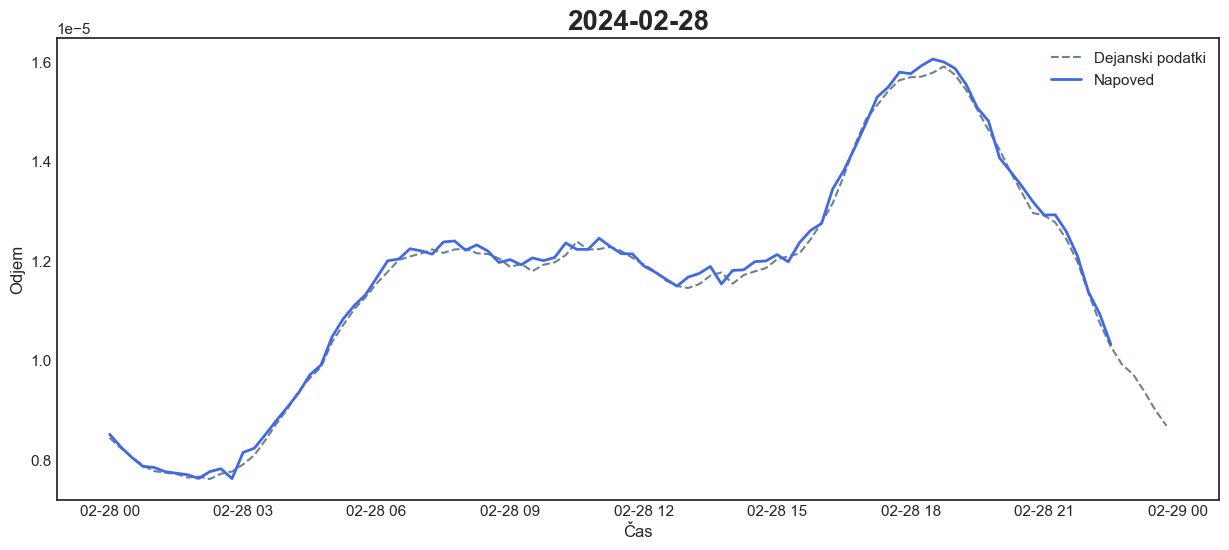

RMSE: 1.346745969095487e-07
MAPE: 0.9523299110234975


In [23]:
napoved_2 = napoved_z_SARIMA_GARCH('2024-02-28')

### 3. Napoved za 5. avgust 2023:

c:\Users\Uporabnik\AppData\Local\Programs\Python\Python39\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\Uporabnik\AppData\Local\Programs\Python\Python39\lib\site-packages\arch\univariate\base.py:311: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0002061. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(


Iteration:      1,   Func. Count:      6,   Neg. LLF: -183060.10629214556
Optimization terminated successfully    (Exit mode 0)
            Current function value: -183060.1063722886
            Iterations: 5
            Function evaluations: 6
            Gradient evaluations: 1


C:\Users\Uporabnik\AppData\Local\Temp\ipykernel_7816\161216951.py:51: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn-white')


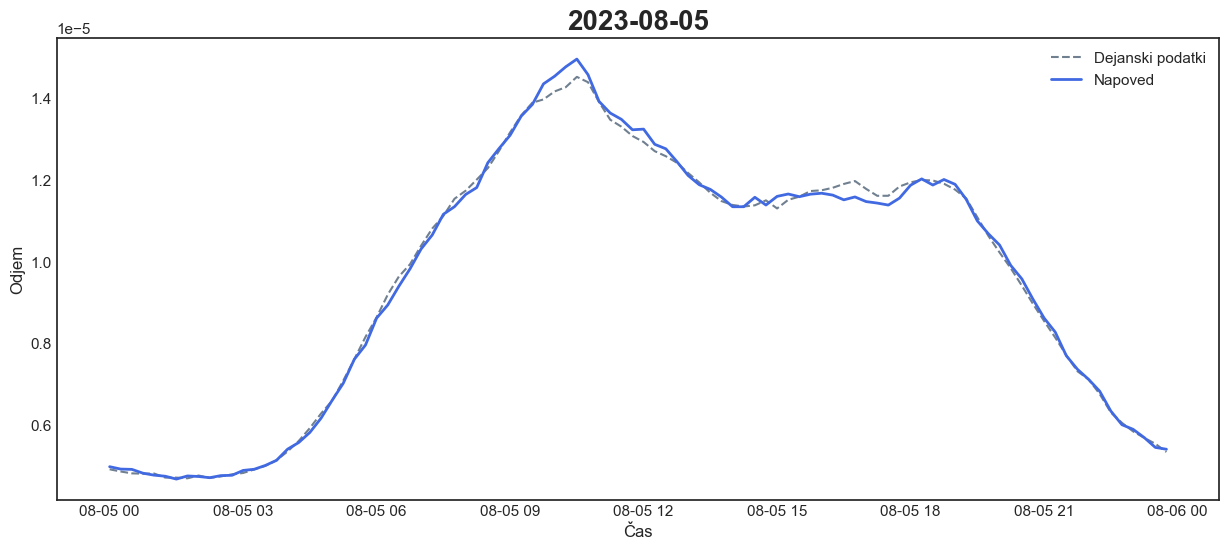

RMSE: 1.5659995790935879e-07
MAPE: 1.1036590467433902


In [24]:
napoved_3 = napoved_z_SARIMA_GARCH('2023-08-05')